# COSC2753 - Assignment 2 - Classify Images of Colon Cancer

**RMIT University Vietnam**

**Course:** COSC2753

**Group:** MK Sapiens

**Student 1:** Pham Cong Minh - s3818102

**Student 2:** Nguyen Bao Khang - s3817970

**Lecturer:** Dr. Duy Dang Pham Thien

**Submission Due Date:** 21 May 2021

## Main task
* Classify images according to whether given cell image represents a cancerous cells or not (isCancerous).
* Classify images according to cell-type, such as: fibroblast, inflammatory, epithelial or others.

## 1. Setup notebook

In [33]:
# !pip install tensorflow
# !pip install keras
!pip install opencv-python

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


## 2. Data inspecting

### 2.1. Load csv files

In [35]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

In [36]:
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [37]:
main_data.shape

(9896, 6)

In [38]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [39]:
extra_data.shape

(10384, 4)

### 2.2. Inspect csv files

From the specifications, the main_data contains both cellType (0 to 3) and isCancerous (0 and 1), while extra_data only contains isCancerous.

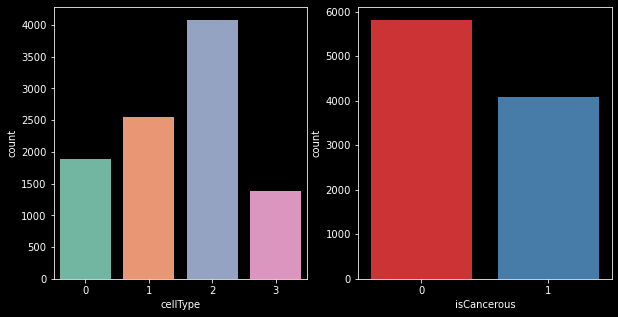

In [40]:
plt.style.use('dark_background')

# Countplot the cellType and isCancerous
fig, ax =plt.subplots(1,2, figsize = (10,5))

# 0 = fibroblast, 1 = imflammatory, 2 = epithelial, 3 = others
sns.countplot(main_data['cellType'], palette='Set2', ax=ax[0])

sns.countplot(main_data['isCancerous'], palette='Set1', ax=ax[1])
fig.show()

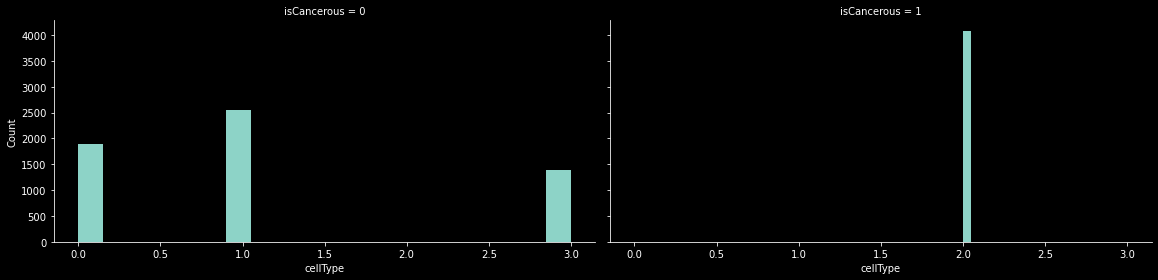

In [41]:
# Draw the histogram for cellType respected to isCancerous (class 0 and 1)
c = 'cellType'
g = sns.FacetGrid(main_data, col='isCancerous', height=4, aspect=2)
g.map(plt.hist, str(c), bins=20)
g.set_axis_labels(c, "Count")

In [42]:
# Apply loc to make sure
main_data.loc[(main_data['cellType'] != 2) & (main_data['isCancerous'] == 1)]

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous


From the dataset, it can be said that only cellType = 2 (epithelial) leads to cancerous 

### 2.3. Inspect images

In [43]:
# Prepare some image of each class
cell0 = main_data['ImageName'].loc[main_data['cellType'] == 0][:4].tolist()
cell1 = main_data['ImageName'].loc[main_data['cellType'] == 1][:4].tolist()
cell2 = main_data['ImageName'].loc[main_data['cellType'] == 2][:4].tolist()
cell3 = main_data['ImageName'].loc[main_data['cellType'] == 3][:4].tolist()

print(cell0)
print(cell1)
print(cell2)
print(cell3)

['22405.png', '22406.png', '22407.png', '22408.png']
['22417.png', '22418.png', '22419.png', '22420.png']
['276.png', '277.png', '278.png', '279.png']
['22423.png', '22424.png', '19061.png', '19062.png']


In [44]:
# CHANGE THE DIRECTORY IN YOUR LOCAL MACHINE
PATH = r"C:\Users\User\Desktop\RMIT\Cloud - GitHub\Minh\ML\Asm\ASM2\patch_images"

## 3. Data preparation

### 3.1. Split data into train and validation (test) set

In [45]:
from sklearn.model_selection import train_test_split

# Split data into raw train and validation set
# Task 1: Predict isCancerous
raw_train_task1, val_task1 = train_test_split(main_data[['ImageName', 'isCancerous']], 
                                              test_size=0.3, 
                                              random_state=99)

# Task 2: Predict cellType
raw_train_task2, val_task2 = train_test_split(main_data[['ImageName','cellType']], 
                                              test_size=0.3, 
                                              random_state=99)                                        

print('Train shape:', raw_train_task2.shape, 'Validation shape:', val_task2.shape)

Train shape: (6927, 2) Validation shape: (2969, 2)


In [46]:
raw_train_task1 = raw_train_task1.sort_values(by=['isCancerous']).reset_index(drop = True)
train_X1 = raw_train_task1['ImageName']
train_Y1 = raw_train_task1['isCancerous']

test_X1 = val_task1['ImageName']
test_Y1 = val_task1['isCancerous']

In [47]:
raw_train_task2 = raw_train_task2.sort_values(by=['cellType']).reset_index(drop = True)
train_X2 = raw_train_task2['ImageName']
train_Y2 = raw_train_task2['cellType']

test_X2 = val_task2['ImageName']
test_Y2 = val_task2['cellType']

### 3.2. Create sample image to balance among classes

In [48]:
train_Y1.value_counts()

0    4067
1    2860
Name: isCancerous, dtype: int64

In [49]:
train_Y2.value_counts()

2    2860
1    1780
0    1313
3     974
Name: cellType, dtype: int64

In [50]:
from random import randint, choice

item_order1 = train_Y1.value_counts().index.tolist()
freq_order1 = train_Y1.value_counts().tolist()

count_list1 = [element for _, element in sorted(zip(item_order1, freq_order1))]# List of value_counts in isCancerous

sum_range1 = count_list1.copy()
for i in range(1, len(sum_range1)):
    sum_range1[i] += sum_range1[i - 1]

sum_range1.insert(0, 0)

MAX1 = max(count_list1)

INTERPOLATION = [cv2.INTER_AREA, cv2.INTER_CUBIC, cv2.INTER_LINEAR, cv2.INTER_NEAREST]

def create_train_isCancerous(directory, img_list):
    train_data = []

    # Add original data 
    for name in tqdm(img_list, desc="Adding original images"):
        img_path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(img_path), (27, 27))
        train_data.append(np.array(img))

    # Add sample data
    for i in tqdm(range(MAX1 - count_list1[1]), desc="Sampling class 1"):
      img_path = os.path.join(directory, choice(img_list[sum_range1[1]:]))
      img = cv2.resize(cv2.imread(img_path), (27, 27), interpolation=INTERPOLATION[randint(0, 3)])
      train_data.append(np.array(img))

    print("\nSuccessfully sample images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [51]:
item_order2 = train_Y2.value_counts().index.tolist()
freq_order2 = train_Y2.value_counts().tolist()

count_list2 = [element for _, element in sorted(zip(item_order2, freq_order2))]# List of value_counts in cellType

sum_range2 = count_list2.copy()
for i in range(1, len(sum_range2)):
    sum_range2[i] += sum_range2[i - 1]

sum_range2.insert(0, 0)

MAX2 = max(count_list2)

def create_train_cellType(directory, img_list):
    train_data = []

    # Add original data 
    for name in tqdm(img_list, desc="Adding original images"):
        img_path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(img_path), (27, 27))
        train_data.append(np.array(img))

    for i in range(4):
        if i != 2:
            for j in tqdm(range(MAX2 - count_list2[i]), desc="Sampling class ".format(fc=i)):
                img_path = os.path.join(directory, choice(img_list[sum_range2[i]:sum_range2[i + 1]]))
                img = cv2.resize(cv2.imread(img_path), (27, 27), interpolation=INTERPOLATION[randint(0, 3)])
                train_data.append(np.array(img))

    print("\nSuccessfully sample images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [52]:
def create_test_data(directory, img_list):
    test_data = []
    for name in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(path), (27, 27))
        test_data.append(np.array(img))
    print("\nSuccessfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(test_data).astype('float32') / 255.0 

### 3.3. Create image array

In [53]:
train_img_X1 = create_train_isCancerous(PATH,train_X1.to_list())

train_img_X1.shape

Sampling class 1: 100%|██████████████████████████████████████████████████████████| 1207/1207 [00:00<00:00, 7858.61it/s]



Successfully sample images!


(8134, 27, 27, 3)

In [54]:
train_img_X2 = create_train_cellType(PATH, train_X2.to_list())

train_img_X2.shape

Sampling class : 100%|███████████████████████████████████████████████████████████| 1886/1886 [00:00<00:00, 8330.61it/s]


Successfully sample images!


(11440, 27, 27, 3)

In [55]:
test_img_X1 = create_test_data(PATH, test_X1.to_list())
test_img_X2 = create_test_data(PATH, test_X2.to_list())

test_img_X2.shape

Extracting Image Progress:  32%|████████████████                                  | 954/2969 [00:00<00:00, 9468.11it/s]


Successfully import images!


Extracting Image Progress: 100%|█████████████████████████████████████████████████| 2969/2969 [00:00<00:00, 9332.08it/s]


Successfully import images!


(2969, 27, 27, 3)

In [56]:
train_mod_Y1 = train_Y1.values
for i in range(2):
  train_mod_Y1 = np.concatenate((train_mod_Y1, np.full((MAX1 - count_list1[i],), i, dtype=int)))

train_mod_Y1.shape

(8134,)

In [57]:
train_mod_Y2 = train_Y2.values
for i in range(4):
  train_mod_Y2 = np.concatenate((train_mod_Y2, np.full((MAX2 - count_list2[i],), i, dtype=int)))

train_mod_Y2.shape

(11440,)

In [58]:
test_Y2.shape

(2969,)

In [59]:
# Create datagen
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

train_datagen1 = datagen.flow(train_img_X1, train_mod_Y1, batch_size=16, shuffle=True)
train_datagen2 = datagen.flow(train_img_X2, train_mod_Y2, batch_size=16, shuffle=True)

## 4. Constructing CNN network

### 4.1. Model for task 1: isCancerous

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

model_isCancerous = Sequential()  # Initiate the model

# First convolutional layer(s)
model_isCancerous.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.2))

# Second convolutional layer(s)
model_isCancerous.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.3))

# Third convolutional layer(s)
model_isCancerous.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.4))

# Fully connected layer(s)
model_isCancerous.add(Flatten())
model_isCancerous.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Dropout(0.2))
model_isCancerous.add(Dense(512, kernel_regularizer=l2(l=0.01), activation='relu'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Dropout(0.2))
model_isCancerous.add(Dense(2, activation='softmax')) # Output is 0 and 1

model_isCancerous.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)       

## 5. Compile and training

In [61]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.0005, beta_1=0.4, beta_2=0.444, decay=1.0e-6, amsgrad=True)

model_isCancerous.compile(optimizer=opt , loss='sparse_category_crossentropy', metrics=['accuracy'])

In [62]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15) 

EPOCHS = 500
BATCH_SIZE = 64

In [ ]:
import time
start_time = time.time()
history_1 = model_isCancerous.fit(train_datagen1, 
                                  validation_data=(test_img_X1, test_Y1), 
                                  batch_size=BATCH_SIZE, 
                                  epochs=EPOCHS, 
                                  verbose=1,
                                  callbacks=[reduce_lr, early])

print("---  Training cellType model in seconds ---%s " % (time.time() - start_time))

Epoch 1/500
509/509 [==============================] - 21s 39ms/step - loss: 18.7198 - accuracy: 0.7700 - val_loss: 16.4588 - val_accuracy: 0.5945
Epoch 2/500
509/509 [==============================] - 19s 38ms/step - loss: 15.0711 - accuracy: 0.8551 - val_loss: 13.7845 - val_accuracy: 0.6787
Epoch 3/500
509/509 [==============================] - 19s 38ms/step - loss: 12.9321 - accuracy: 0.8548 - val_loss: 12.0976 - val_accuracy: 0.7110
Epoch 4/500
509/509 [==============================] - 19s 38ms/step - loss: 11.3371 - accuracy: 0.8577 - val_loss: 10.6417 - val_accuracy: 0.6868
Epoch 5/500
509/509 [==============================] - 20s 38ms/step - loss: 10.0542 - accuracy: 0.8676 - val_loss: 9.5954 - val_accuracy: 0.7221
Epoch 6/500
509/509 [==============================] - 19s 38ms/step - loss: 9.0136 - accuracy: 0.8676 - val_loss: 8.5478 - val_accuracy: 0.7801
Epoch 7/500
509/509 [==============================] - 19s 38ms/step - loss: 8.1255 - accuracy: 0.8719 - val_loss: 7.7787

In [ ]:
scores_isCancerous = model_isCancerous.evaluate(test_img_X1, test_Y1, verbose=1)
print('Validation loss:', scores_isCancerous[0])
print('Validation accuracy:', scores_isCancerous[1])
print('Max Validation accuracy:', max(history_1.history['accuracy']))

# summarize history for accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()